### GEN AI POWERED LLM AWS-SERVICE BOT

The following are the goals of this project:

1. Training a large dataset of 25,175 documents along with 100 matched questions and answers. These questions are inspired by the author's interactions with real AWS customers and the questions they asked about AWS services. The data was anonymized and aggregated. All questions in the dataset have a valid, factual and unambiguous answer within the accompanying documents, we deliberately avoided questions that are ambiguous, incomprehensible, opinion-seeking, or not clearly a request for factual information. All questions, answers and accompanying documents in the dataset are annotated by authors. There are two types of answers: text and yes-no-none(YNN) answers. Text answers range from a few words to a full paragraph sourced from a continuous block of words in a document or from different locations within the same document.

2. Aid the user in their AWS cloud adoption process, by helping them understand the proper needs and solutions to their problems.

3. Use a variety of AWS frameworks/services to be able to make this a possibility.

We will be using the following architecture to build this out:

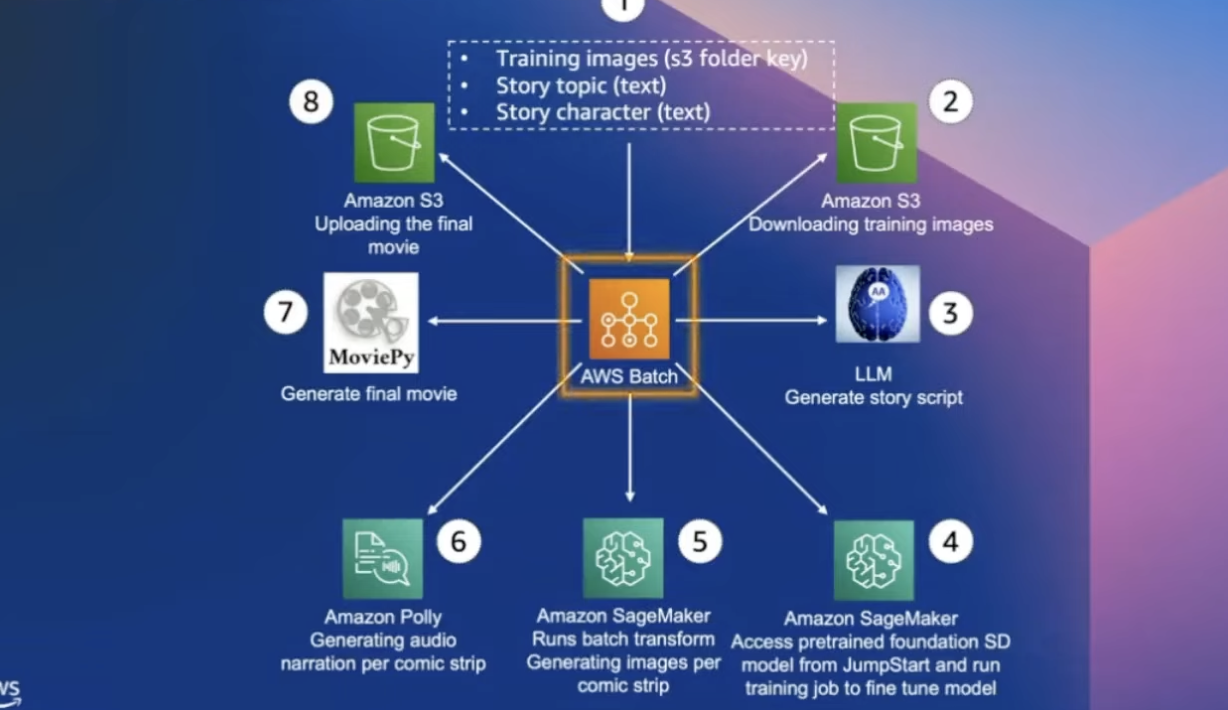

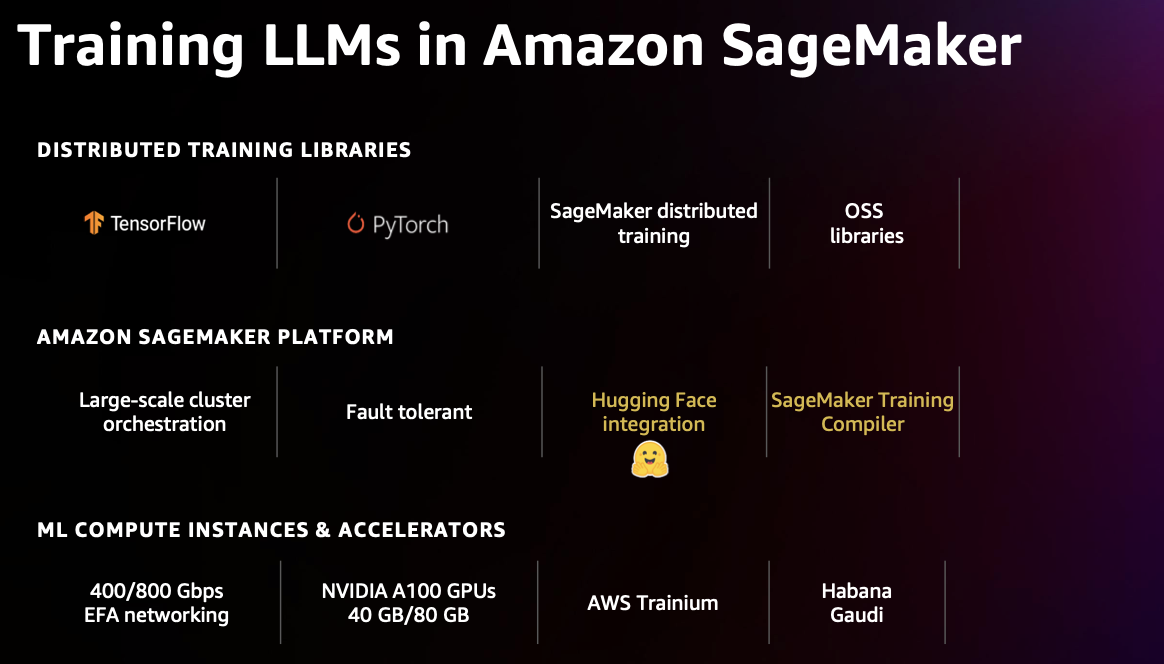

#### We will be using distributed training in deploying an LLM:

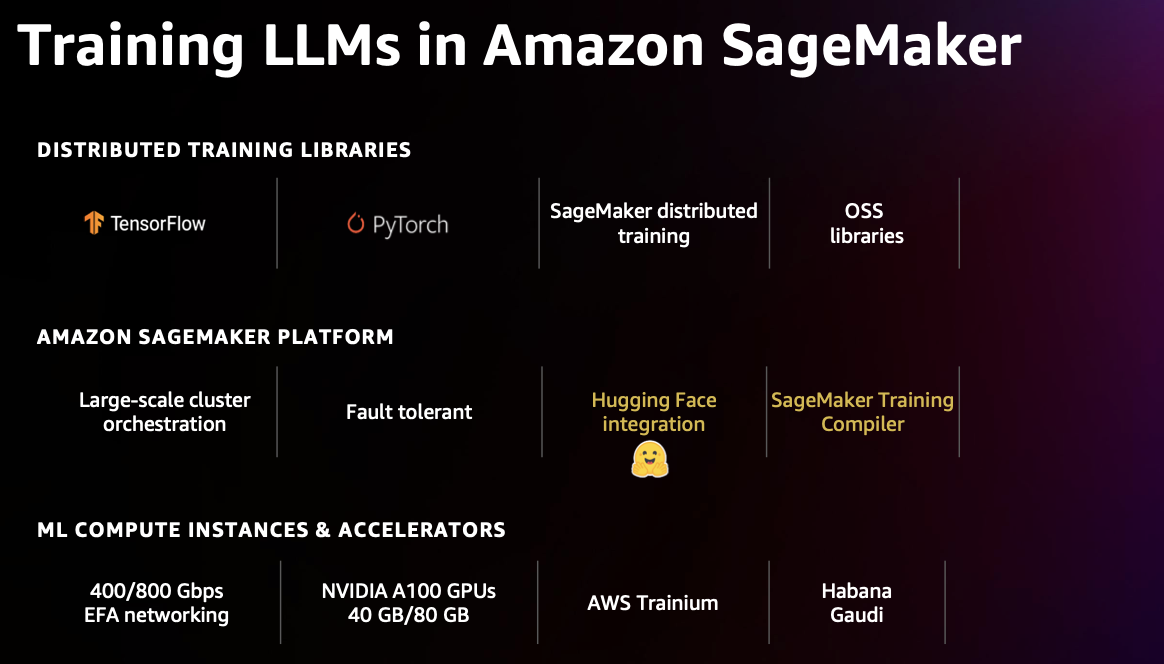

### To consider while deploying Generative AI on SageMaker:

1. Complexity: One way complexity can manifest is through the size of the given model that we are working with - for example, Flan-T5. There are multiple tokens, dimensions and the size that needs to be considered.

2. Cost: Whenever we are deploying a model, we need an endpoint/host to serve for an inference. Also, when we are doing some fine tuning, we are going to train and provide additional cost/data - more time associated with training

3. Performance: One of the key areas - teaching the model, giving it context to give more accuracy and precision, and we need to get an answer as soon as possible. For example, a chat for a Q&A - millions of transactions with a high throughput.


### MODEL SIZE:

For example, if we take a GPT-J 6 Billion, we got to consider the training, and the model serving. For example, for training, we need to consider the size of the training data in each of the instances. 

When it comes to model serving, we are going to need at least 2 times the model size CPU - for the initial weight and the checkpoint.

### Optimizing models for hosting with SageMaker:

1. Large Model Inference Optimization: Optimization can occur at software and hardware level. Here, we will focus on the software level. The first thing we consider is:
    1. Model compilation: this approach results better
    performance and accuracy.
    
    2. Model compression: Approach to compress models to 
    deliver faster results. The downside of this is that
    we are decreasing accuract in favor of speed.

2. Model Partitioning

3. Prompt Engineering

We can use these to optimize the model serving. Some of these can reduce the runtime, increase accuracy and performance, and so on.


### LARGE MODEL HOSTING & OPTIMIZATION PIPELINE

Process:

1. Model Optimization: In training or post training. 

2. Model download

3. Model loading and serving

4. Multi-GPU inference

5. Prompt Engineering


### WHAT IS THE LMI (LARGE MODEL INFERENCE) CONTAINER?

This is one of the models we use to support models with billions of parameters and a massive amount of data. We use this model within sagemaker. 

We are able to leverage deep speed, huggingface. 

### HOSTING GPT-J-6B MODEL ON MULTIPLE GPUs

1. Amazon SageMaker Endpoint: 

2. DJLServing (model server)

3. DeepSpeed Inference

4. Model (Tensor) Parallelism

### FIRST, HOST A LARGE LANGUAGE MODEL ON SAGEMAKER USING A DEEPSPEED CONTAINER

#### STEP 1: CREATE A SAGEMAKER MODEL FOR DEPLOYMENT

In [2]:
## Here, we will import the relevant libraries and configure the 
## global variables, such as the hosting image that we will use
## and the location of the S3 bucket of our model artifacts

!pip install sagemaker boto3 --upgrade --quiet

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
import sagemaker
from sagemaker.model import Model
from sagemaker import serializers, deserializers
from sagemaker import image_uris
import boto3
import os
import time
import json
import jinja2
from pathlib import Path

#### Now, work with GPT-J-6B

In [4]:
## Represents getting the execution role for the endpoint
role = sagemaker.get_execution_role()

## Represents starting the sagemaker session to interact with the necessary AWS APIs
sess = sagemaker.session.Session()

## Creating a bucket to store the model artifcats
bucket_store = sess.default_bucket()
model_bucket = sess.default_bucket()

## Creating the prefix of the folder of the bucket where the model artifacts will be stored
code_prefix = 'large-model-djl-gptj6b/code'

## Represents the folder where the checkpoint will go
model_prefix = 'large-model-djl-gptj6b/model'

In [5]:
## Represents setting up the region name of the current session
region = sess._region_name

## Account of the current sagemaker session
account_id = sess.account_id()

print(region, account_id)

us-east-1 988564344122


In [6]:
## Represents connecting to the S3 API
s3_client = boto3.client("s3")

## Represents connecting to the client that interacts with SageMaker
sm_client = boto3.client("sagemaker")

## Represents the client that can interact with the endpoints
endpoint_client = boto3.client("sagemaker-runtime")

## Represents the jinja environment to generate model confirguration templates
jinja_env = jinja2.Environment()

/opt/conda/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [7]:
## Represents creating the inference image uri based on the current region

inference_image_uri = (
    
    ## This is the inference image we will use to do distributed training - only for a single GPU for this example
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116"
    
)

print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.20.0-deepspeed0.7.5-cu116


In [8]:
## Now, looking up the S3 model location based on our region

pretrained_model_location = f"s3://sagemaker-examples-files-prod-{region}/models/gpt-j-6b-model"
print ("We can download our pretrained model from: ", pretrained_model_location)

We can download our pretrained model from:  s3://sagemaker-examples-files-prod-us-east-1/models/gpt-j-6b-model


## DEPLOYING AN LLM USING HUGGING FACE ACCELERATE

Now, we will use this for either text-generation, question answering, test-classification, or token-classification.

In [9]:
## Now, we will plug in the model location into our serving.properties file, based on the region of this notebook we defined
template = jinja_env.from_string(Path("serving.properties").open().read())

Path("serving.properties").open("w").write(
    template.render(s3url=pretrained_model_location)
)

!pygmentize serving.properties | cat -n

     1	engine = Python
     2	option.entryPoint = djl_python.huggingface
     3	option.s3url = s3//sagemaker-examples-files-prod-us-east-1/models/gpt-j-6b-model/
     4	option.task = test-classification
     5	option.device_map=auto
     6	option.load_in_8bit=TRUE


In [10]:
## Now, we place the serving.properties file into a tarball into s3
!tar czvf acc_model.tar.gz serving.properties

serving.properties


In [11]:
hf_s3_code_artifact = sess.upload_data("acc_model.tar.gz", bucket_store, code_prefix)
print (hf_s3_code_artifact)

s3://sagemaker-us-east-1-988564344122/large-model-djl-gptj6b/code/acc_model.tar.gz


## Deploying Model to SageMaker Endpoint

In [12]:
## Represents the helper function to create the SageMaker Endpoint resources and get a predictor

def deploy_model(image_uri, model_data, role, endpoint_name, instance_type, sagemaker_session):
    
    model = Model(image_uri = image_uri, model_data = model_data, role = role)
    
    model.deploy(initial_instance_count = 1, instance_type = instance_type, endpoint_name = endpoint_name)
    
    predictor = sagemaker.Predictor(
        endpoint_name = endpoint_name,
        sagemaker_session = sagemaker_session, 
        serializer = serializers.JSONSerializer(),
        deserializer = deserializers.JSONDeserializer(),
    )
    
    return predictor

In [13]:
## Now, we will create an endpoint name
hf_endpoint_name = sagemaker.utils.name_from_base("gptj-acc")
print ("our endpoint: ", hf_endpoint_name)

our endpoint:  gptj-acc-2023-07-27-16-48-57-496


In [14]:
## Now, we will deploy the model using the endpoint name and the helper function that we created above

hf_predictor = deploy_model(
    image_uri = inference_image_uri, 
    model_data = hf_s3_code_artifact, 
    role = role, 
    endpoint_name = hf_endpoint_name,
    instance_type = "ml.g4dn.4xlarge",
    sagemaker_session = sess,
)

------------!

In [16]:
## Now, let's use one example to see what happens when we use a general, basic promt

hf_predictor.predict(
    {"inputs": "Machine learning can be", "parameters": {"max_length": 55, "temperature": 0.5}}
)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (424) from primary with message "{
  "code":424,
  "message":"prediction failure",
  "error":"You need to define 'task' options."
}". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/gptj-acc-2023-07-27-16-48-57-496 in account 988564344122 for more information.